# 402 RNN

View more, visit my tutorial page: https://mofanpy.com/tutorials/
My Youtube Channel: https://www.youtube.com/user/MorvanZhou

Dependencies:
* torch: 0.1.11
* matplotlib


In [17]:
import torch
from torch import nn
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
torch.manual_seed(1)    # reproducible

# 參數

In [19]:
# Hyper Parameters(超參數)
EPOCH = 1   #(訓練迭代次數)            # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 64 #每一次訓練批量大小(每一次撈64筆樣本)
TIME_STEP = 28 #時間序列長度,做預測會考慮多久以前的時間軸         # rnn time step / image height
INPUT_SIZE = 28 #輸入特徵維度         # rnn input size / image width
# 圖片(寬28長28)
LR = 0.01 #學習率(梯度下降每更新一次步長參數)              # learning rate
DOWNLOAD_MNIST = True #要不要下載MNIST資料集  # set to True if haven't download the data

# 下載訓練資料

In [20]:
# Mnist digital dataset
train_data = dsets.MNIST(
    root='./mnist/',
    train=True,                         # this is training data
    transform=transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                        # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,            # download it if you don't have it
)

# 採樣一筆訓練資料(圖片) 繪製出來

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


torch.Size([60000, 28, 28])
torch.Size([60000])


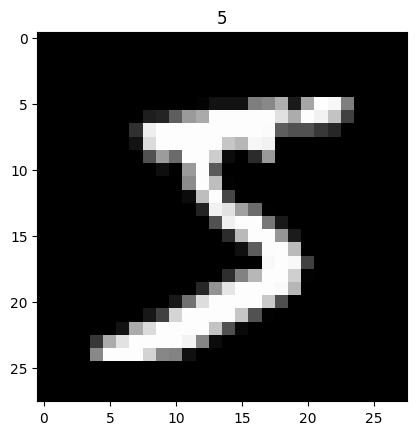

In [21]:
# plot one example
print(train_data.train_data.size())     # (60000, 28, 28) 6萬張圖片 長28 寬28
print(train_data.train_labels.size())   # (60000)
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()

# 把資料做成PYTORCH Data Loader 格式 方便做批量訓練

In [22]:
# Data Loader for easy mini-batch return in training
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

# 測試資料 test_data 對模型(訓練後)做驗證

In [23]:
# convert test data into Variable, pick 2000 samples to speed up testing
test_data = dsets.MNIST(root='./mnist/', train=False, transform=transforms.ToTensor())
test_x = Variable(test_data.test_data, volatile=True).type(torch.FloatTensor)[:2000]/255.   # shape (2000, 28, 28) value in range(0,1)
test_y = test_data.test_labels.numpy().squeeze()[:2000]    # covert to numpy array

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
<ipython-input-23-5235ae4c11eb>:3: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  test_x = Variable(test_data.test_data, volatile=True).type(torch.FloatTensor)[:2000]/255.   # shape (2000, 28, 28) value in range(0,1)
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


# 循環神經網路RNN(LSTM版本)

In [24]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.LSTM(         #如果單純RNN 很難訓練所以改用LSTM # if use nn.RNN(), it hardly learns
            input_size=INPUT_SIZE,#(輸入特徵維度) 這裡是28 因為圖片寬度是28
            hidden_size=64, #隱藏層神經元數量(影響到模型能力愈多愈強可是運算資源消耗更大時間更久才能收斂)        # rnn hidden unit
            num_layers=1, #幾個隱藏層 這裡設1個(愈多層能力愈強收斂很慢)          # number of rnn layer
            batch_first=True, #要不要 BATCH_SIZE 當作第一個shape      # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )

        self.out = nn.Linear(64, 10)

    def forward(self, x):
        # x shape (batch, time_step, input_size)
        # r_out shape (batch, time_step, output_size)
        # h_n shape (n_layers, batch, hidden_size)
        # h_c shape (n_layers, batch, hidden_size)
        # 輸入x代入rnn模塊,None代表說初始化隱藏向量h_n(時間點0),h_c(時間點0)的數值是None代表0
        r_out, (h_n, h_c) = self.rnn(x, None)   # None represents zero initial hidden state
        # r_out:在特定時間點的輸出,(h_n, h_c)在特定時間的隱藏層數值
        # choose r_out at the last time step
        out = self.out(r_out[:, -1, :])#第一個維度是batch_size維度,第二個維度時間軸(取-1代表最後一個時間點的值),第三個是特徵維度
        return out

In [25]:
rnn = RNN()
print(rnn)

RNN(
  (rnn): LSTM(28, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)


In [26]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)   #優化器 adam
loss_func = nn.CrossEntropyLoss() #損失函數 分類任務 使用CrossEntrop 交叉墒

In [27]:
# training and testing
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):        # 採樣一小批量的樣本
        b_x = Variable(x.view(-1, 28, 28)) # reshape x to (batch, time_step, input_size)
        b_y = Variable(y)   # batch y

        output = rnn(b_x) #一個批量(batch)的x(輸入)丟入 rnn 計算 output(輸出)(預測值)
        loss = loss_func(output, b_y) # 將預測值和標準答案倆倆計算一下 交叉墒損失
        # 梯度清空(歸零) => 損失loss反向傳播 => 優化器optimizer更新rnn權重"一次"
        optimizer.zero_grad()                           # clear gradients for this training step
        loss.backward()                                 # backpropagation, compute gradients
        optimizer.step()                                # apply gradients

        # 當每迭代50步
        if step % 50 == 0:
            # 用test data 做評估 看目前的模型 準確度accuracy如何?
            test_output = rnn(test_x)                   # (samples, time_step, input_size)
            pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
            accuracy = sum(pred_y == test_y) / float(test_y.size)
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.item(), '| test accuracy: %.2f' % accuracy)


Epoch:  0 | train loss: 2.3088 | test accuracy: 0.09
Epoch:  0 | train loss: 1.3109 | test accuracy: 0.59
Epoch:  0 | train loss: 0.7657 | test accuracy: 0.73
Epoch:  0 | train loss: 0.6890 | test accuracy: 0.77
Epoch:  0 | train loss: 0.2135 | test accuracy: 0.83
Epoch:  0 | train loss: 0.2512 | test accuracy: 0.89
Epoch:  0 | train loss: 0.3412 | test accuracy: 0.90
Epoch:  0 | train loss: 0.3512 | test accuracy: 0.92
Epoch:  0 | train loss: 0.0860 | test accuracy: 0.94
Epoch:  0 | train loss: 0.0828 | test accuracy: 0.94
Epoch:  0 | train loss: 0.1309 | test accuracy: 0.93
Epoch:  0 | train loss: 0.2273 | test accuracy: 0.95
Epoch:  0 | train loss: 0.1981 | test accuracy: 0.95
Epoch:  0 | train loss: 0.1883 | test accuracy: 0.95
Epoch:  0 | train loss: 0.0918 | test accuracy: 0.95
Epoch:  0 | train loss: 0.1744 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0325 | test accuracy: 0.96
Epoch:  0 | train loss: 0.2735 | test accuracy: 0.95
Epoch:  0 | train loss: 0.0978 | test accuracy

In [29]:
# print 10 predictions from test data
test_output = rnn(test_x[:10].view(-1, 28, 28))
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(pred_y, 'prediction number')
print(test_y[:10], 'real number')

[7 2 1 0 4 1 4 9 6 9] prediction number
[7 2 1 0 4 1 4 9 5 9] real number


In [30]:
test_x[-2].view(-1, 28, 28)

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


torch.Size([60000, 28, 28])
torch.Size([60000])


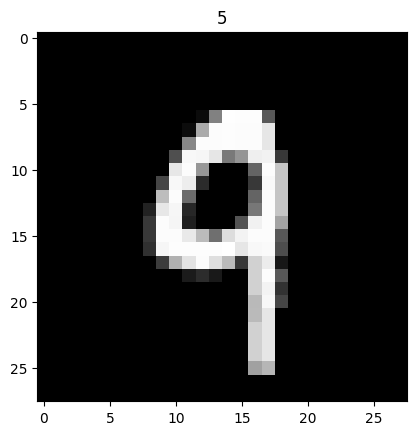

In [31]:
# plot one example
print(train_data.train_data.size())     # (60000, 28, 28) 6萬張圖片 長28 寬28
print(train_data.train_labels.size())   # (60000)
plt.imshow(test_x[-2].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()